# Data Context


The main focus of the research is to investigate the value of Federated Learning techniques on a Predictive Maintenance use-case using operational data from multiple airline fleets, within a consortium governed Digital Data Marketplace (DDM) ecosystem. In the real world, there will be no direct access to this operational data as the this data is held privately and is confidential. The main idea of Federated Learning is to train a model across multiple decentralized edge nodes holding local data, without exposing or transmitting privately held data. For the actual experiments within a DDM, airline operational dataset(s) related to Boeing aircraft(s) such as 787 Supplemental Cooling Unit(SCU), or 747 Bleed Air Valves will be used. This data is private and is expected to be made available by the  participating airline KLM, within the DDM ecosystem, in the month of April 2023. 

As an alternative to private and confidential airline operational datasets, publicly available dataset is  being explored during the research to make comparisons between centralized and federated learning methods. This simulated dataset is provided by the NASA Ames Prognostics Center of Excellence (PCoE). Engine degradation simulation was carried out using the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS). Four different sets (FD001, FD002, FD003, FD004) were simulated under different combinations of operational conditions and fault modes. This records several sensor channels to characterize fault evolution. <BR>


<B>References</B> :
    
1. Data Set Download: https://data.nasa.gov/Aerospace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6 
2. Data Set Citation: A. Saxena, K. Goebel, D. Simon, and N. Eklund, Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation, in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

# Data Description

### Data Set
All the data sets consist of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. The data set also includes a vector of true Remaining Useful Life (RUL) values for the test data.

There are 4 datasets available as part of the CMAPSS download. Data Set FD001 is used as the public dataset for this research project. The dataset includes train data, test data and ground truth Remaining Useful Life (RUL) values for the test data. Further, for Federated Learning experiments, the training data will be split into one subset for initial training (10 engines) and 3 subsets for each of Federated Learning Nodes (30 engines each). The test data will also be split for validation and testing.<BR>

### Structure
The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:
1)	unit number<BR>
2)	time, in cycles<BR>
3)	operational setting 1<BR>
4)	operational setting 2<BR>
5)	operational setting 3<BR>
6)	sensor measurement  1<BR>
7)	sensor measurement  2<BR>
...<BR>
26)	sensor measurement  26<BR>

### Analysis 
* Data Set FD001 has data from 100 engines and has 20631 entries. 
* 'Operational setting 3', and Sensor Measurements 1, 5, 6, 10, 16, 18,19 have constant values and hence hold no information related to RUL.
* Correlation : There is high correlation ( close to 1 or -1 )  between the following sensor pairs: (4,11), (4,12), (7,11), (7,12), (8,13), (9,14), (11,12)
* Target Variable: A  variable for Remaining User Life (RUL) will be computed. This will also serve as a target variable for supervised learning.As there is no information about RUL in the training data, we assume that the RUL decreases linearly with time and will have a value of 0 at the last time cycle of the engine. The calculated RUL and the histogram show that most engines breakdown around 200 cycles and the distribution is right skewed.
* Trends : The various sensor plots w.r.t RUL show that Sensors 1, 5, 10, 16, 18 and 19 do not indicate a increasing or decreasing trend. They are constant. Sensors 2, 3, 4, 8, 11, 13, 15 and 17 indicate an increasing trend. Sensor 7, 12, 20, 21 indicate an declining trend. Sensor  6 peaks downwards but is not clear. Sensor 9 and Sensor 14 display similar pattern with gradual change for a while and then indicate an abrupt increasing or decreasing trend, at certain point in time.
* Experiments : Regression experiments to predict the RUL value, using supervised learning will be setup and performed in the Federated Learning Environment. The picture below depcits the overall flow including the data that will be used. The results from federated learning will then be compared to (non-federated) centralized learning methods.

    
![image](eda-1.png)

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns; 

### Data Loading

In [ ]:
# CMAPSS FD001 DataSet 

In [2]:
# define filepath to read data
dir_path = '../data/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Descriptive Statistics


In [ ]:
train.info()

In [ ]:
# Number of  engines
len(train['unit_nr'].unique())

In [ ]:
# inspect unit_nr
train[index_names].describe()

In [ ]:
# time cycles
train[index_names].groupby('unit_nr').max().describe()

In [ ]:
# settings
train[setting_names].describe()

In [ ]:
# sensor values
train[sensor_names].describe().transpose()

In [ ]:
cols_nan = train.columns[train.isna().any()].tolist()
print('Columns without data: \n' + str(cols_nan) + '\n')

In [ ]:
train.count()

### Target Variable - Remaining Useful Life (RUL)

In [3]:
#Compute Remaining Useful Life(RUL) of the component
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


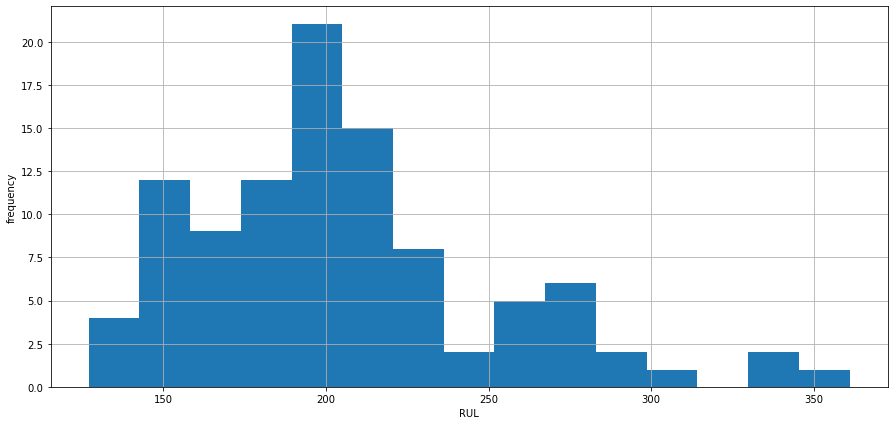

In [4]:
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()
# Most Engines break down around 200 cycles and the distribution is right skewed

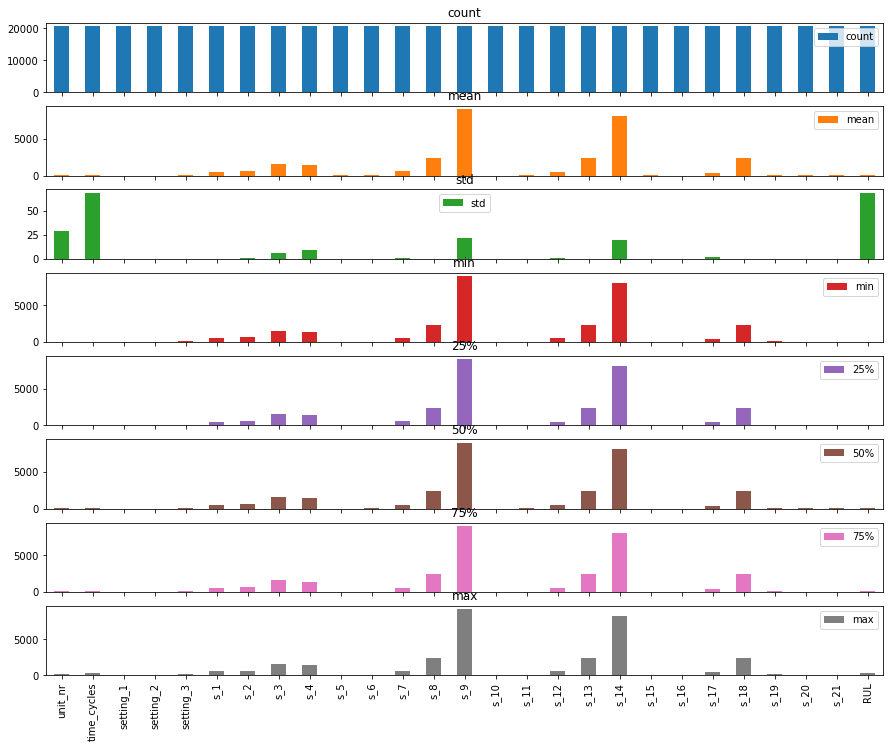

In [5]:
# plot of all columns
axes = train.describe().T.plot.bar(subplots=True, figsize=(15,12))

In [6]:
#There are a few columns with constant values
cols_const = [ col for col in train.columns if len(train[col].unique()) <= 2 ]
print('Columns with constant values: \n' + str(cols_const) + '\n')
#Columns with constant values: 
#['setting_3', 's_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

Columns with constant values: 
['setting_3', 's_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']



### Correlations

<AxesSubplot:>

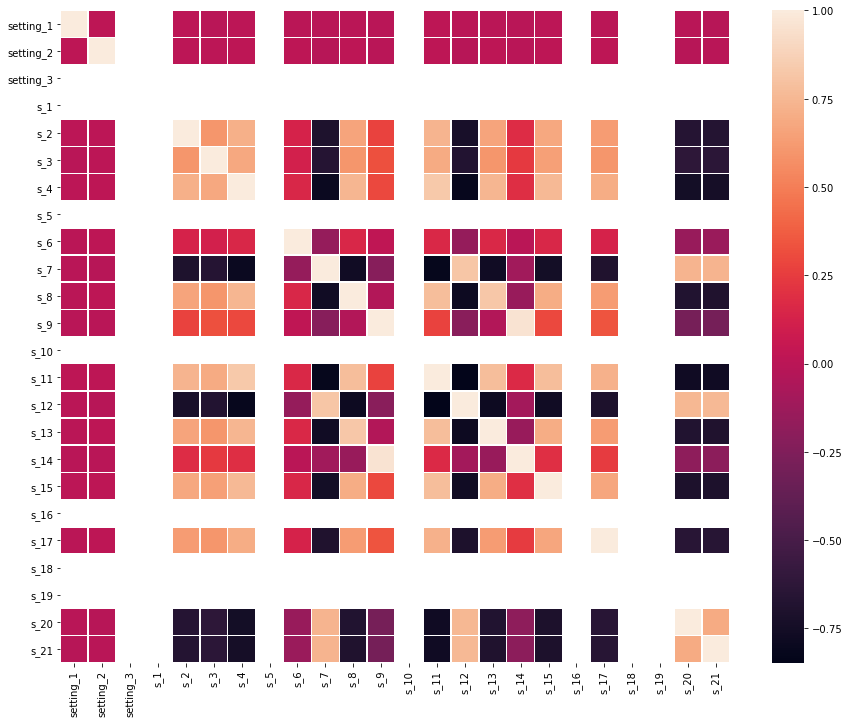

In [7]:
# print correlation heatmap
analysis_corr = train[setting_names + sensor_names].corr(method='pearson')
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(analysis_corr, linewidths=.5)

In [8]:
# print highly correlated values
analysis_corr2 = pd.DataFrame(np.tril(analysis_corr.values), columns=analysis_corr.columns, index = analysis_corr.index)

correlating = []
for col in analysis_corr2.columns:
    ser = analysis_corr2[col]
    idx = np.logical_or(-0.8 > ser,  ser > 0.8)
    for i, c in zip(ser[idx].index, ser[idx].values):
        if (i, col, c) not in correlating and i != col:
            correlating.append((col, i, c))

print('Highly correlating values:')
for c in correlating:
    print(c)

Highly correlating values:
('s_4', 's_11', 0.8301356963159815)
('s_4', 's_12', -0.815590516105214)
('s_7', 's_11', -0.8228050249957691)
('s_7', 's_12', 0.812712601325414)
('s_8', 's_13', 0.8260843322333569)
('s_9', 's_14', 0.9631566003059776)
('s_11', 's_12', -0.8468835930051095)


### Trends

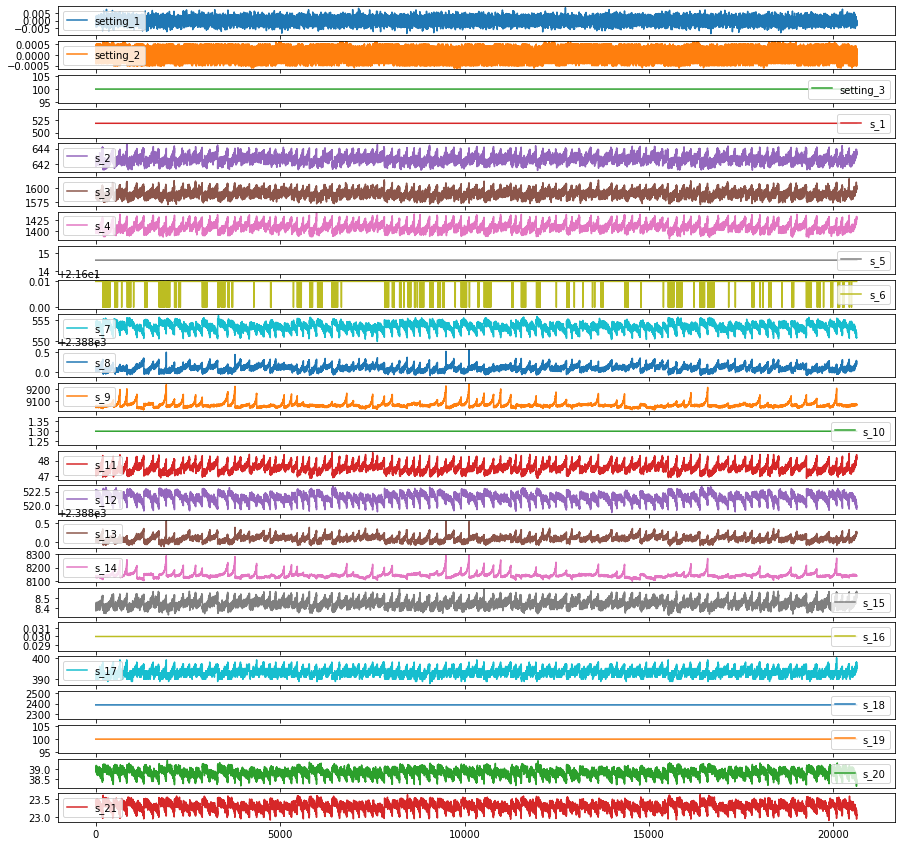

In [11]:
# plot all train data - settings, sensors
t = train[setting_names + sensor_names].plot(subplots=True, figsize=(15, 15))

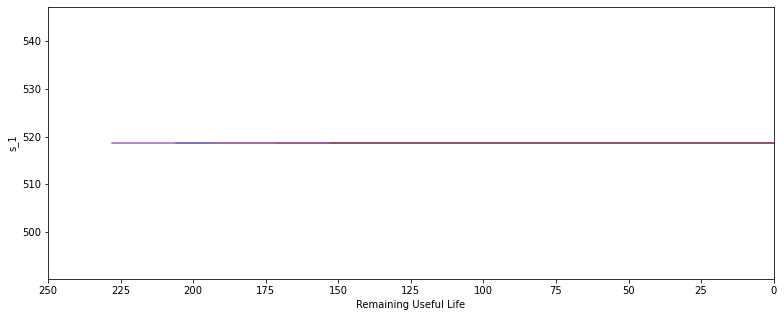

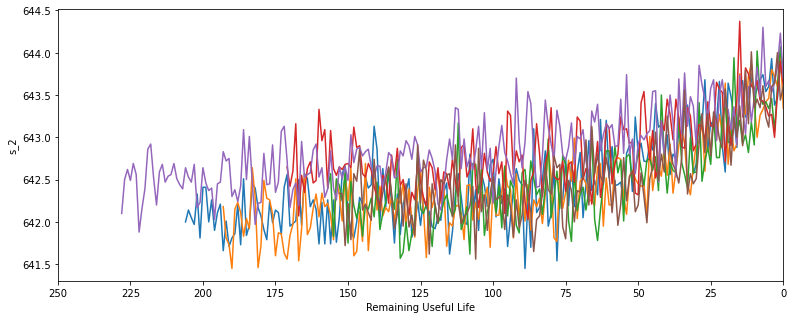

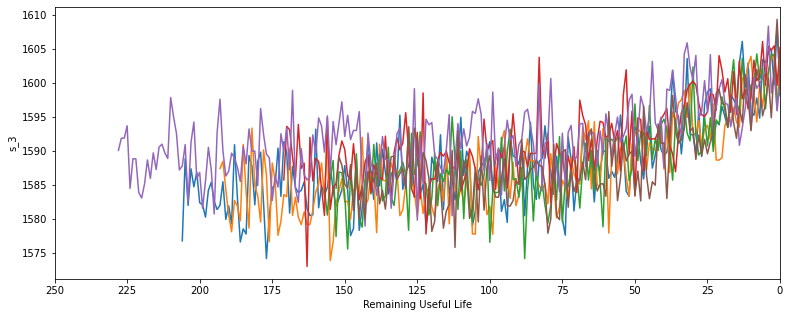

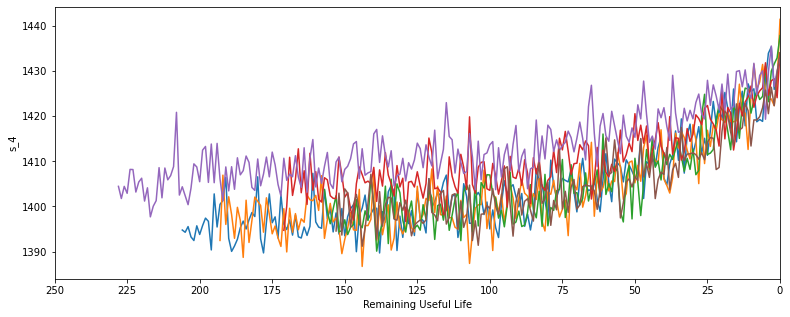

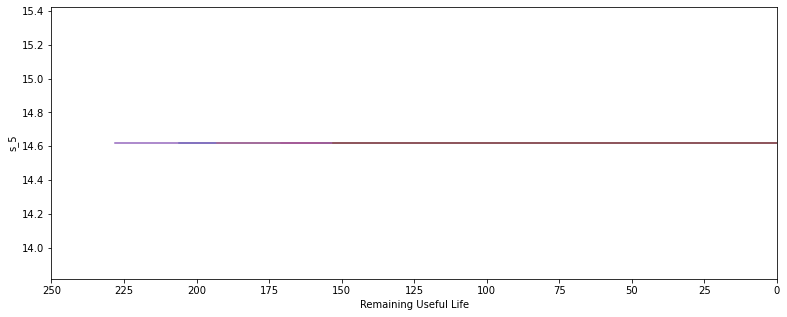

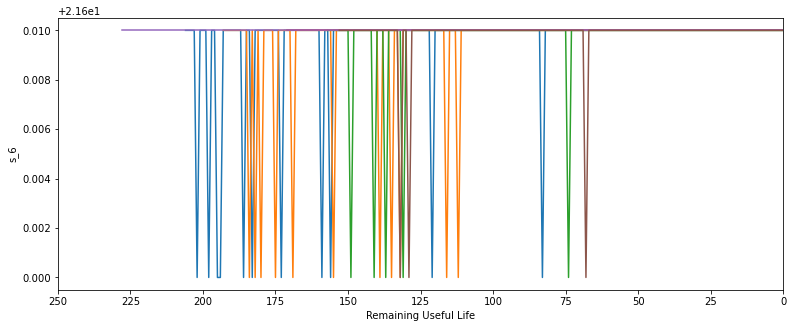

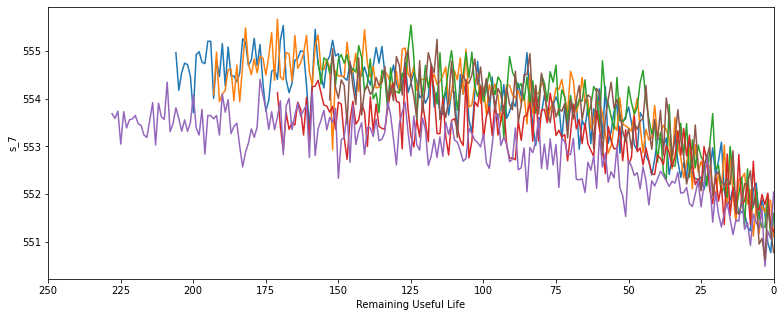

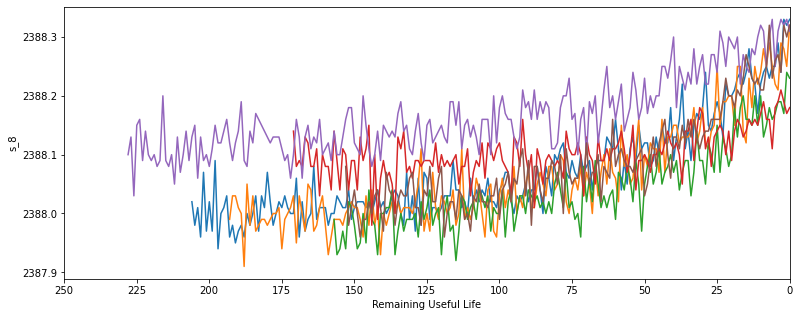

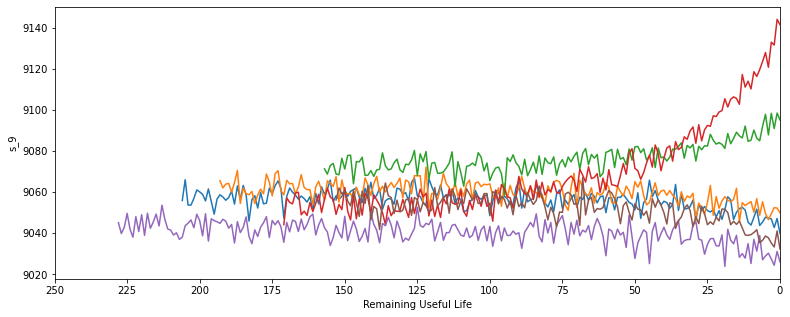

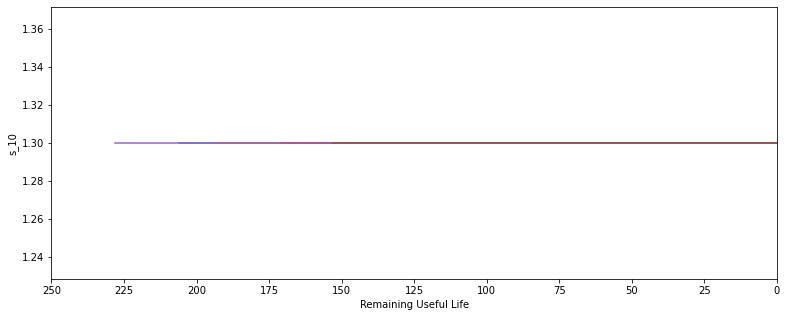

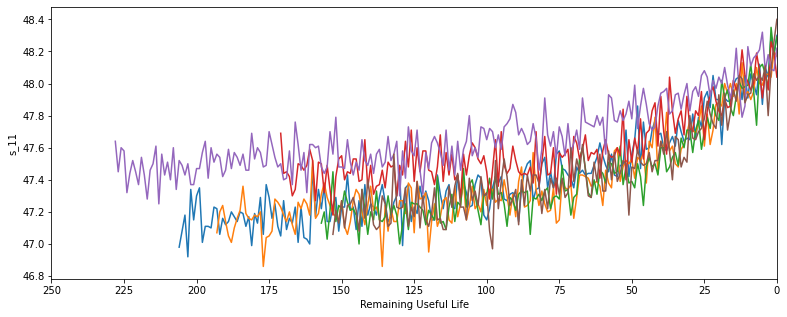

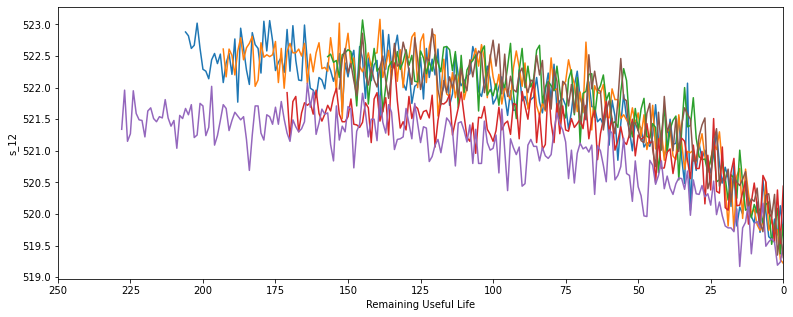

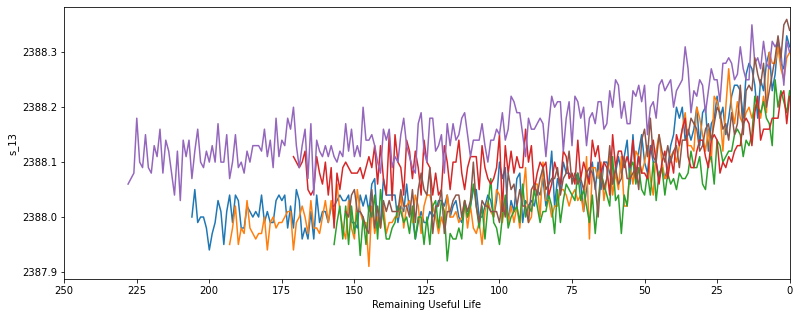

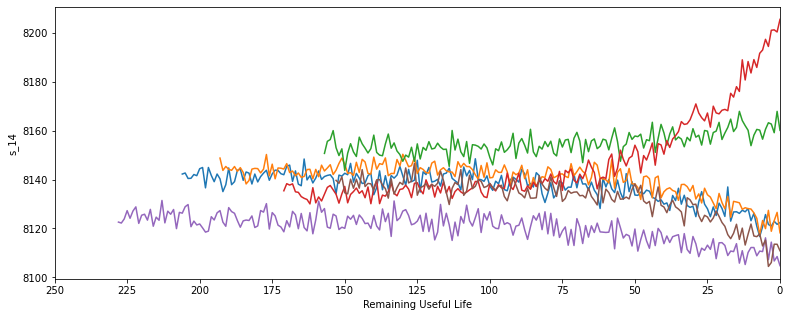

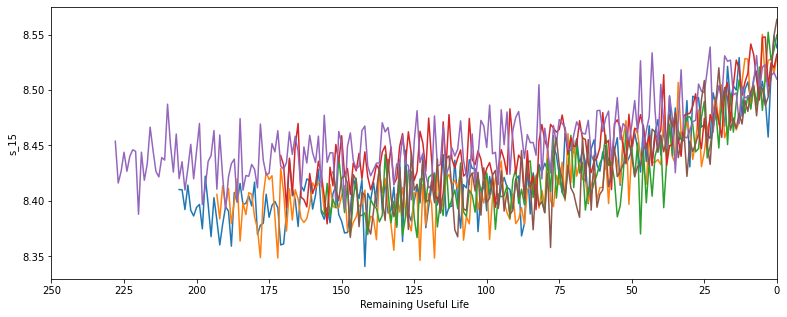

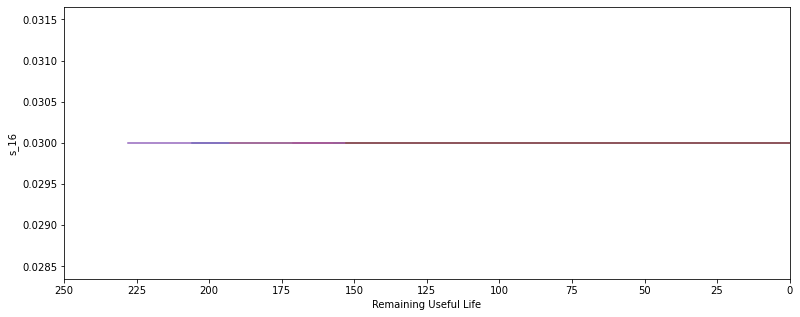

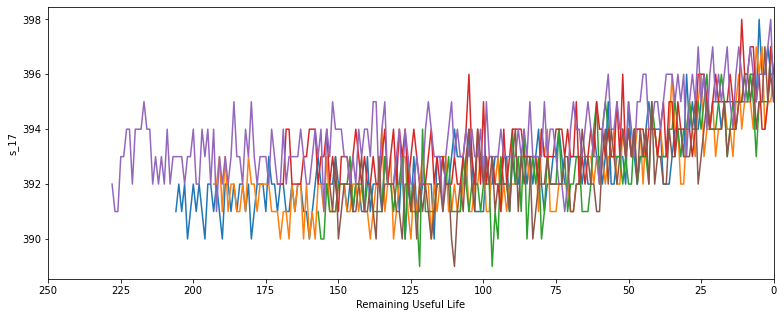

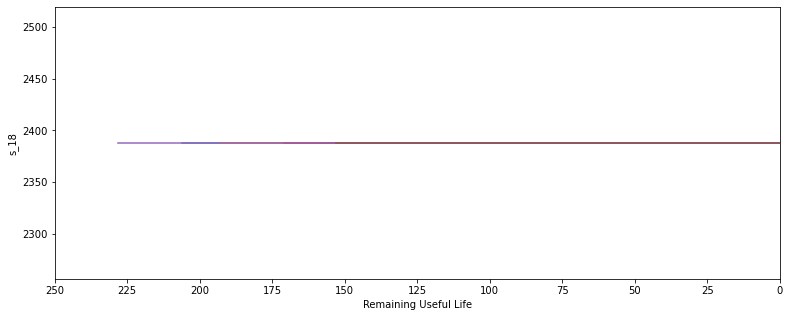

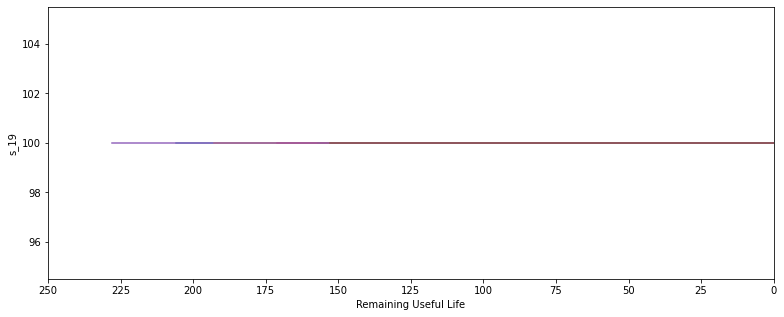

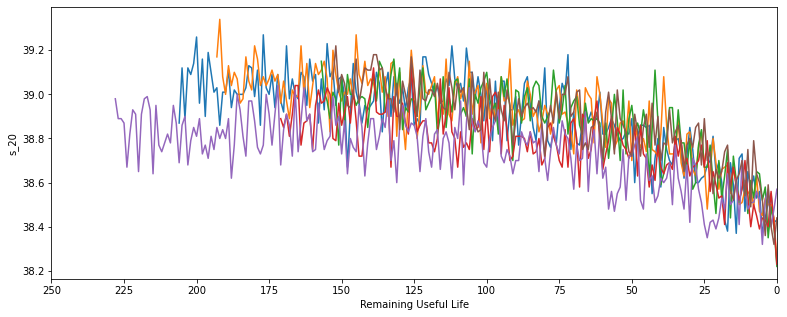

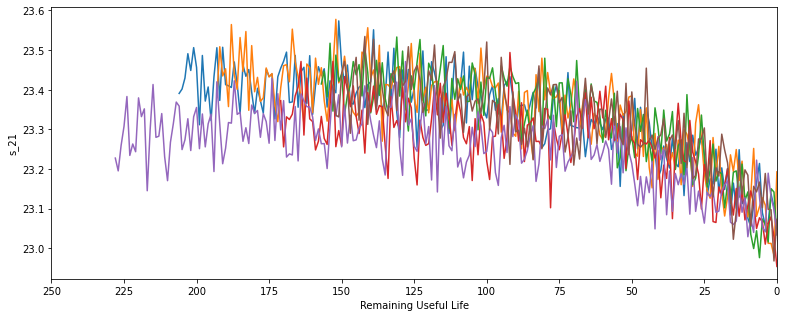

In [9]:
# Plot each sensor
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 15 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

# Plot Sensors w.r.t RUL and observe the trends
# Constant : Sensors 1, 5, 10, 16, 18, 19 
# Rising Trend : Sensors 2, 3, 4, 8, 11, 13, 15, 17 
# Declining Trend: Sensor 7, 12, 20, 21 
# Others: 
#        Sensor 6 peaks downwards. 
#        Sensors 9, 14 display similar pattern, gradual change for a while and then abrupt increase or decrease.

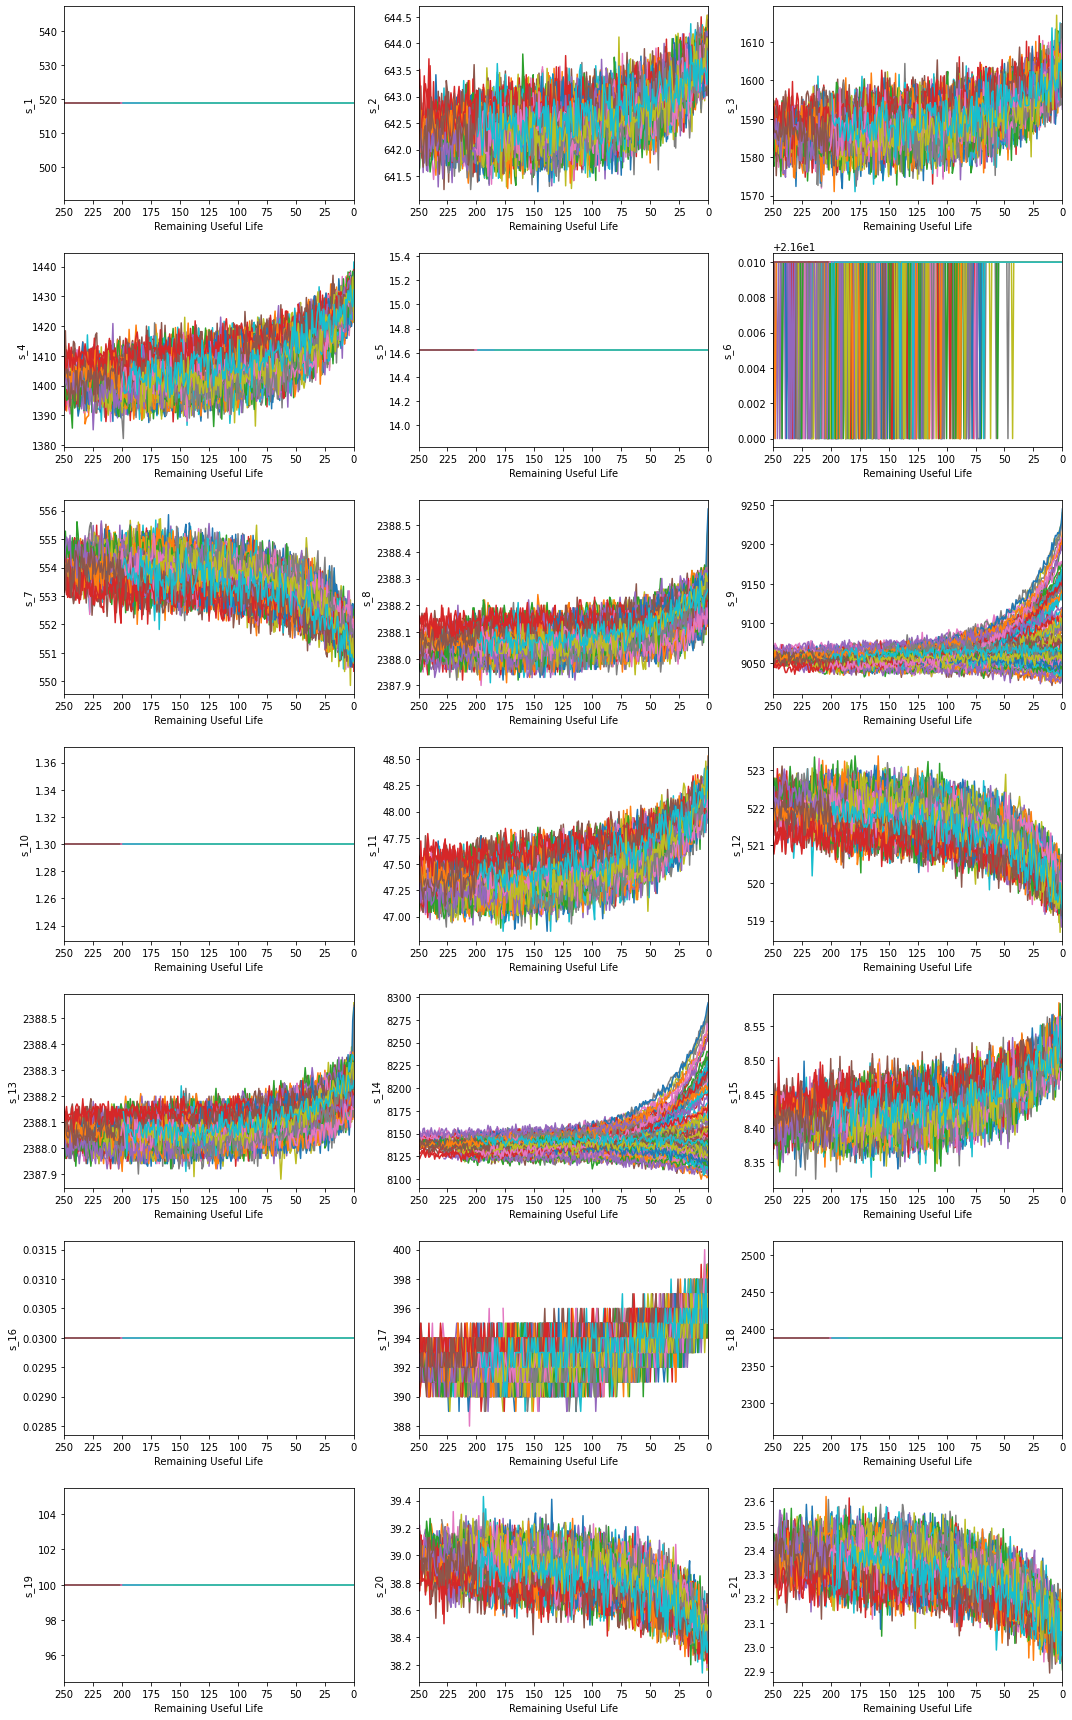

In [13]:
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15, 24))

for i, sensor_name in enumerate(sensor_names):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    for j in train['unit_nr'].unique():
        #if (j % 10 == 0):
            ax.plot('RUL', sensor_name, data=train[train['unit_nr']==j])
    ax.set_xlim(250, 0)
    ax.set_xticks(np.arange(0, 275, 25))
    ax.set_ylabel(sensor_name)
    ax.set_xlabel('Remaining Useful Life')

plt.tight_layout()
plt.show()


In [14]:
sensor_names

['s_1',
 's_2',
 's_3',
 's_4',
 's_5',
 's_6',
 's_7',
 's_8',
 's_9',
 's_10',
 's_11',
 's_12',
 's_13',
 's_14',
 's_15',
 's_16',
 's_17',
 's_18',
 's_19',
 's_20',
 's_21']